In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

### Load in data

In [2]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_11/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

# Simulation output record path
record_dir = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_11/train')

# Output name prefix
sample_names = 'sample'

obj_dims = (648, 486)

In [3]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

### Load in TFRecord data

In [4]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _create_example(plane, sim):
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=sim.ravel()))
    feature = {
        'plane': plane_feature,
        'sim': sim_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [5]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

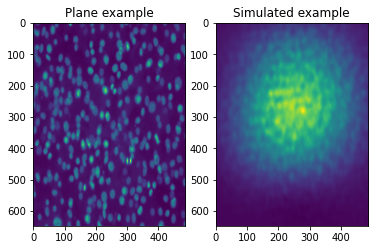

In [6]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

In [7]:
# from skimage import restoration

In [8]:
# sim_example = model.A_svd_2d_no_crop(plane_example, weights, h)

# fig = plt.figure()

# ax1 = plt.subplot(121)
# ax1.imshow(plane_example)
# ax1.set_title("Plane example")

# ax2 = plt.subplot(122)
# ax2.imshow(sim_example)
# ax2.set_title("Simulated example")

# plt.show()

In [9]:
# deconvolved = restoration.unsupervised_wiener(sim_example, h.squeeze())[0]

# plt.imshow(crop_2d(deconvolved) / weights.squeeze())
# plt.title("Wiener deconvolution result")

In [16]:
Ah_b_2d = model.A_adj_svd_2d(sim_example, weights, h)

def A2d_inv_cg(x, alpha_cg):
    return model.A_adj_svd_2d(model.A_svd_2d(x, weights, h), weights, h) + alpha_cg*x

def cgsolve(z, b, Niter, alpha_cg):
    #b is A*y
    #solving z=M-1b
    r=b-A2d_inv_cg(z, alpha_cg)
    p=r.copy()
    rsold=np.conj(np.sum(r*r))
    print('loss ', rsold)
    for i in range(0,Niter):
        Ap=A2d_inv_cg(p, alpha_cg)
        alpha=rsold/(np.conj(np.sum(p*Ap)))
        z=z+alpha*p
        r=r-alpha*Ap
        
        rsnew=np.conj(np.sum(r*r))
        if np.sqrt(rsnew)<1e-10:
            break
            
        p=r+(rsnew/rsold)*p
        rsold=rsnew
        print('loss ',rsold)
    return z

In [17]:
Niter=20
z_wiener=np.zeros(np.shape(sim_example))
x_wiener=cgsolve(z_wiener,Ah_b_2d,Niter, 1e-4)

loss  1666.3353174635006
loss  6.917658608931315
loss  0.4266909643564436
loss  0.18440076273138925
loss  0.09632139878853684
loss  0.06651264377506508
loss  0.036257072245498026
loss  0.014555284334715573
loss  0.009374365114311424
loss  0.007475533503072286
loss  0.0034683330578844816
loss  0.0021317851182849658
loss  0.013861535416876226
loss  0.001451273162623299
loss  0.0010387672014397391
loss  0.0006597683087174432
loss  0.00043935181529127605
loss  0.00042065107938879965
loss  0.00028450575449058747
loss  0.0001582633214478537
loss  0.0010451605148565101


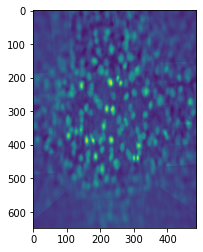

In [18]:
plt.imshow(x_wiener)

In [13]:
Ah_b_2d = model.A_adj_svd_2d_tf(sim_example, weights, h)

def A2d_inv_cg_tf(x, alpha_cg):
    return model.A_adj_svd_2d_tf(model.A_svd_2d_tf(x, weights, h), weights, h) + alpha_cg*x

def cgsolve(z, b, Niter, alpha_cg):
    #b is A*y
    #solving z=M-1b
    r=b-A2d_inv_cg_tf(z, alpha_cg)
    p=tf.identity(r)
    rsold=tf.math.conj(tf.math.reduce_sum(r*r))
    print('loss ', rsold)
    for i in range(0,Niter):
        Ap=A2d_inv_cg_tf(p, alpha_cg)
        alpha=rsold/(tf.math.conj(tf.math.reduce_sum(p*Ap)))
        z=z+alpha*p
        r=r-alpha*Ap
        
        rsnew=tf.math.conj(tf.math.reduce_sum(r*r))
        if np.sqrt(rsnew)<1e-10:
            break
            
        p=r+(rsnew/rsold)*p
        rsold=rsnew
        print('loss ',rsold)
    return z

In [14]:
Niter=20
z_wiener=np.zeros(np.shape(sim_example))
x_wiener=cgsolve(z_wiener,Ah_b_2d,Niter, 1e-4)

loss  tf.Tensor(1666.3345, shape=(), dtype=float32)
loss  tf.Tensor(6.917654, shape=(), dtype=float32)
loss  tf.Tensor(0.42669034, shape=(), dtype=float32)
loss  tf.Tensor(0.18440078, shape=(), dtype=float32)
loss  tf.Tensor(0.09632818, shape=(), dtype=float32)
loss  tf.Tensor(0.07060933, shape=(), dtype=float32)
loss  tf.Tensor(0.08328785, shape=(), dtype=float32)
loss  tf.Tensor(0.054457992, shape=(), dtype=float32)
loss  tf.Tensor(0.0140303625, shape=(), dtype=float32)
loss  tf.Tensor(0.009051309, shape=(), dtype=float32)
loss  tf.Tensor(0.007574733, shape=(), dtype=float32)
loss  tf.Tensor(0.0049806335, shape=(), dtype=float32)
loss  tf.Tensor(0.009638569, shape=(), dtype=float32)
loss  tf.Tensor(0.0018744302, shape=(), dtype=float32)
loss  tf.Tensor(0.0037506283, shape=(), dtype=float32)
loss  tf.Tensor(0.0017492858, shape=(), dtype=float32)
loss  tf.Tensor(0.0009798901, shape=(), dtype=float32)
loss  tf.Tensor(0.003914506, shape=(), dtype=float32)
loss  tf.Tensor(0.0012739897, sh

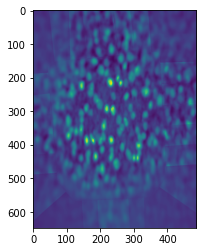

In [15]:
plt.imshow(x_wiener)

## Running simulations with forward model

### Regular

In [13]:
# model = ForwardModel()

# for i, sample in enumerate(dataset):
#     plane = sample['plane'].numpy()
#     sim = model.A_svd_2d(plane, weights, h).astype(np.float16)

#     tf_example = _create_example(plane, sim)
#     record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
#     with tf.io.TFRecordWriter(record_file) as writer:
#         writer.write(tf_example.SerializeToString())

#     if i % 500 == 0:
#         print('sim-%.5d processed' % i)

### With Wiener Deconvolution

In [14]:
model = ForwardModel()

for i, sample in enumerate(dataset):
    plane = sample['plane'].numpy()
    sim = model.A_svd_2d(plane, weights, h).astype(np.float16)
    
    Niter=20
    z_wiener=np.zeros(np.shape(sim_example))
    x_wiener=cgsolve(z_wiener,Ah_b_2d,Niter, 1e-4)

    tf_example = _create_example(plane, x_wiener)
    record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(tf_example.SerializeToString())

    if i % 500 == 0:
        print('sim-%.5d processed' % i)

sim-00000 processed


KeyboardInterrupt: 